In [10]:
import os
import librosa
import numpy as np
import tensorflow as tf
import pandas as pd

In [11]:
train_labels_df = pd.read_csv("edaicwoz/train_split.csv")
test_labels_df = pd.read_csv("edaicwoz/test_split.csv")
val_labels_df = pd.read_csv("edaicwoz/dev_split.csv")

In [12]:
def load_audio_files(data_dir, sr=16000):
    file_ids = os.listdir(data_dir)
    subject_ids = []
    file_paths = []
    types = []
    labels = []
    labels_binary = []

    for file_id in file_ids:
        file_id = file_id.split("_")[0]
        file_path = [data_dir + "/" + file_id + "/" + file_id + "_MFCC_" + str(i) + ".npy" for i in range(len(next(iter(enumerate(os.walk(data_dir + "/" + str(file_id) + "/"))))[1][2]))]
        if int(file_id) in train_labels_df["Participant_ID"].values:
            types.append(0)
            labels.append(train_labels_df[train_labels_df["Participant_ID"] == int(file_id)]['PHQ_Score'].values[0])
            labels_binary.append(train_labels_df[train_labels_df["Participant_ID"] == int(file_id)]['PHQ_Binary'].values[0])
            
        elif int(file_id) in test_labels_df["Participant_ID"].values:
            types.append(1)
            labels.append(test_labels_df[test_labels_df["Participant_ID"] == int(file_id)]['PHQ_Score'].values[0])
            labels_binary.append(test_labels_df[test_labels_df["Participant_ID"] == int(file_id)]['PHQ_Binary'].values[0])
        else:
            types.append(2)
            labels.append(val_labels_df[val_labels_df["Participant_ID"] == int(file_id)]['PHQ_Score'].values[0])
            labels_binary.append(val_labels_df[val_labels_df["Participant_ID"] == int(file_id)]['PHQ_Binary'].values[0])
        subject_ids.append(int(file_id))
        file_paths.append(file_path)

    return file_ids, subject_ids, file_paths, types, labels, labels_binary

data_dir = "MFCCs_1030"

file_ids, subject_ids, file_paths, types, labels, labels_binary = load_audio_files(data_dir)

In [13]:
def prepare_audio_set(file_paths):

    samples = []
    samples_ids = []
    samples_types = []
    samples_labels = []
    samples_labels_binary = []

    for i, file_path in enumerate(file_paths):
        all_mfccs = []
        for j in range(len(file_path)):
            all_mfccs.append(np.load(file_path[j]))
        all_mfccs = np.array(all_mfccs)
        samples.extend(all_mfccs)
        samples_ids.extend([subject_ids[i]] * len(all_mfccs))
        samples_types.extend([types[i]] * len(all_mfccs))
        samples_labels.extend([labels[i]] * len(all_mfccs))
        samples_labels_binary.extend([labels_binary[i]] * len(all_mfccs))

    samples = np.array(samples)

    samples_ids = np.array(samples_ids)
    samples_types = np.array(samples_types)
    samples_labels = np.array(samples_labels)
    samples_labels_binary = np.array(samples_labels_binary)

    return samples, samples_ids, samples_types, samples_labels, samples_labels_binary

print("[INFO] preparing data...")
samples, samples_ids, samples_types, samples_labels, samples_labels_binary = prepare_audio_set(file_paths)
samples = np.swapaxes(samples, 1, 2)

[INFO] preparing data...


In [14]:
training_samples = samples[samples_types == 0]
training_labels = samples_labels_binary[samples_types == 0]
training_subject_ids = samples_ids[samples_types == 0]

test_samples = samples[samples_types == 1]
test_labels = samples_labels_binary[samples_types == 1]

val_samples = samples[samples_types == 2]
val_labels_df = samples_labels_binary[samples_types == 2]

In [15]:
training_samples.shape

(2350, 15001, 13)

In [16]:
import numpy as np

class DataGeneratorVanilla(tf.keras.utils.Sequence):
    def __init__(self, x_set, y_set, batch_size=256):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.indices = np.arange(self.x.shape[0])

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        inds = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x = self.x[inds]
        batch_y = self.y[inds]
        return batch_x, batch_y
    
    def on_epoch_end(self):
        np.random.shuffle(self.indices)

print("[INFO] constructing training/testing split...")
train_gen = DataGeneratorVanilla(training_samples, training_labels, 32)
test_gen = DataGeneratorVanilla(test_samples, test_labels, 32)
val_gen = DataGeneratorVanilla(val_samples, val_labels_df, 32)

[INFO] constructing training/testing split...


In [17]:
(training_labels == 0).sum()

1240

In [18]:
(training_samples.shape[0], training_samples.shape[1], training_samples.shape[2])

(2350, 15001, 13)

In [22]:
def create_cnn_model(input_shape):
    model = tf.keras.models.Sequential()
    
    model.add(tf.keras.layers.GRU(units = 64, input_shape = input_shape)) # , return_sequences=True
    # model.add(tf.keras.layers.GRU(units = 32))

    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    return model

lr = 0.0003
label_smooth = 0.1

classification_reports = []
histories = []
predictions = []

for _ in range(10):
    model = create_cnn_model((training_samples.shape[1], training_samples.shape[2]))

    print("[INFO] compiling model...")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=label_smooth), metrics=['accuracy'])

    model.summary()

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    print("[INFO] fitting model...")
    history = model.fit(train_gen, epochs=100, validation_data=val_gen, callbacks=[early_stopping])

    from tqdm import tqdm

    test_preds = []

    file_ids = os.listdir("edaicwoz/merge")
    test_label_file = pd.read_csv("edaicwoz/test_split.csv")

    for file_id in tqdm(file_ids):
        if int(file_id) in test_label_file["Participant_ID"].values:
            all_mfccs = []
            for j in range(10):
                file_path = "MFCCs_1030/" + file_id + "/" + file_id + "_MFCC_" + str(j) + ".npy"
                all_mfccs.append(np.load(file_path))
            all_mfccs = np.array(all_mfccs)
            all_mfccs = np.swapaxes(all_mfccs, 1, 2)
            prediction = model.predict(all_mfccs, verbose=0, batch_size=8)
            prediction = prediction.mean(axis=0)
            test_preds.append(prediction)

    label_file = test_label_file
    true = label_file.to_numpy()[:, 2].flatten().tolist()
    predicted = (np.array(test_preds) > 0.5).astype(np.int32).flatten().tolist()

    true_labels = true
    predicted_labels = predicted

    from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
    from sklearn.metrics import classification_report
    import matplotlib.pyplot as plt

    def create_confusion_matrix(true_labels, predicted_labels):
        true_labels = np.array(true_labels)
        predicted_labels = np.array(predicted_labels)
        cm = confusion_matrix(true_labels, predicted_labels)
        return cm

    def plot_confusion_matrix(conf_matrix, classes):
        plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        for i in range(len(classes)):
            for j in range(len(classes)):
                plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='white' if conf_matrix[i, j] > conf_matrix.max() / 2 else 'black')

        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

    def calculate_metrics(true_labels, predicted_labels):
        precision = precision_score(true_labels, predicted_labels)
        recall = recall_score(true_labels, predicted_labels)
        f1 = f1_score(true_labels, predicted_labels)

        return precision, recall, f1

    classes = ['0', '1']

    # Calculate precision, recall, and F1-score for both classes
    classification_report = classification_report(true_labels, predicted_labels, target_names=classes)

    histories.append(history)
    predictions.append(predictions)
    classification_reports.append(classification_report)

    del model

lowest_loss = float('inf')
lowest_loss_index = -1

for i, history in enumerate(histories):
    val_loss = history.history['val_loss'][-6] # we're using -6 since patience of early stopping is 5
    if val_loss < lowest_loss:
        lowest_loss = val_loss
        lowest_loss_index = i

print("The run with the lowest validation loss is run: ", lowest_loss_index)

print("Classification report for the run that has lowest validation error:")
print(classification_reports[lowest_loss_index])

print("Predictions for the run that has lowest validation error:")
print(predictions[lowest_loss_index])

[INFO] compiling model...
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_30 (GRU)                (None, 64)                15168     
                                                                 
 dense_60 (Dense)            (None, 32)                2080      
                                                                 
 dropout_30 (Dropout)        (None, 32)                0         
                                                                 
 dense_61 (Dense)            (None, 1)                 33        
                                                                 
Total params: 17,281
Trainable params: 17,281
Non-trainable params: 0
_________________________________________________________________
[INFO] fitting model...
Epoch 1/100
74/74 [==============================] - 55s 724ms/step - loss: 0.7169 - accuracy: 0.5226 - val_loss: 0.6859 - val_accu

100%|██████████| 275/275 [00:35<00:00,  7.64it/s] 

[INFO] compiling model...
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_31 (GRU)                (None, 64)                15168     
                                                                 
 dense_62 (Dense)            (None, 32)                2080      
                                                                 
 dropout_31 (Dropout)        (None, 32)                0         
                                                                 
 dense_63 (Dense)            (None, 1)                 33        
                                                                 
Total params: 17,281
Trainable params: 17,281
Non-trainable params: 0
_________________________________________________________________


[INFO] fitting model...
Epoch 1/100
74/74 [==============================] - 55s 722ms/step - loss: 0.8007 - accuracy: 0.5302 - val_loss: 0.6971 - val_accuracy: 0.5300
Epoch 2/100
74/74 [==============================] - 54s 725ms/step - loss: 0.6925 - accuracy: 0.5817 - val_loss: 0.6896 - val_accuracy: 0.5675
Epoch 3/100
74/74 [==============================] - 54s 732ms/step - loss: 0.6440 - accuracy: 0.6443 - val_loss: 0.6765 - val_accuracy: 0.5663
Epoch 4/100
74/74 [==============================] - 53s 721ms/step - loss: 0.6240 - accuracy: 0.6770 - val_loss: 0.6677 - val_accuracy: 0.5913
Epoch 5/100
74/74 [==============================] - 53s 716ms/step - loss: 0.5989 - accuracy: 0.7128 - val_loss: 0.6590 - val_accuracy: 0.5962
Epoch 6/100
74/74 [==============================] - 53s 716ms/step - loss: 0.5673 - accuracy: 0.7494 - val_loss: 0.6528 - val_accuracy: 0.6125
Epoch 7/100
74/74 [==============================] - 53s 720ms/step - loss: 0.5453 - accuracy: 0.7681 - val_loss

100%|██████████| 275/275 [00:36<00:00,  7.63it/s] 

[INFO] compiling model...
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_32 (GRU)                (None, 64)                15168     
                                                                 
 dense_64 (Dense)            (None, 32)                2080      
                                                                 
 dropout_32 (Dropout)        (None, 32)                0         
                                                                 
 dense_65 (Dense)            (None, 1)                 33        
                                                                 
Total params: 17,281
Trainable params: 17,281
Non-trainable params: 0
_________________________________________________________________


[INFO] fitting model...
Epoch 1/100
74/74 [==============================] - 54s 716ms/step - loss: 0.7118 - accuracy: 0.5379 - val_loss: 0.6733 - val_accuracy: 0.6125
Epoch 2/100
74/74 [==============================] - 53s 716ms/step - loss: 0.6906 - accuracy: 0.5477 - val_loss: 0.6722 - val_accuracy: 0.5763
Epoch 3/100
74/74 [==============================] - 53s 717ms/step - loss: 0.6702 - accuracy: 0.5864 - val_loss: 0.6686 - val_accuracy: 0.6037
Epoch 4/100
74/74 [==============================] - 53s 717ms/step - loss: 0.6567 - accuracy: 0.6221 - val_loss: 0.6702 - val_accuracy: 0.5587
Epoch 5/100
74/74 [==============================] - 54s 726ms/step - loss: 0.6413 - accuracy: 0.6489 - val_loss: 0.6663 - val_accuracy: 0.5975
Epoch 6/100
74/74 [==============================] - 52s 708ms/step - loss: 0.6269 - accuracy: 0.6609 - val_loss: 0.6657 - val_accuracy: 0.6050
Epoch 7/100
74/74 [==============================] - 52s 702ms/step - loss: 0.6095 - accuracy: 0.6915 - val_loss

100%|██████████| 275/275 [00:35<00:00,  7.69it/s] 

[INFO] compiling model...
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_33 (GRU)                (None, 64)                15168     
                                                                 
 dense_66 (Dense)            (None, 32)                2080      
                                                                 
 dropout_33 (Dropout)        (None, 32)                0         
                                                                 
 dense_67 (Dense)            (None, 1)                 33        
                                                                 
Total params: 17,281
Trainable params: 17,281
Non-trainable params: 0


_________________________________________________________________
[INFO] fitting model...
Epoch 1/100
74/74 [==============================] - 53s 708ms/step - loss: 0.7343 - accuracy: 0.5094 - val_loss: 0.6825 - val_accuracy: 0.5550
Epoch 2/100
74/74 [==============================] - 52s 705ms/step - loss: 0.6882 - accuracy: 0.5647 - val_loss: 0.6731 - val_accuracy: 0.5888
Epoch 3/100
74/74 [==============================] - 53s 718ms/step - loss: 0.6631 - accuracy: 0.5953 - val_loss: 0.6702 - val_accuracy: 0.5638
Epoch 4/100
74/74 [==============================] - 53s 717ms/step - loss: 0.6478 - accuracy: 0.6183 - val_loss: 0.6669 - val_accuracy: 0.5663
Epoch 5/100
74/74 [==============================] - 53s 717ms/step - loss: 0.6341 - accuracy: 0.6370 - val_loss: 0.6632 - val_accuracy: 0.5888
Epoch 6/100
74/74 [==============================] - 53s 711ms/step - loss: 0.6080 - accuracy: 0.6774 - val_loss: 0.6713 - val_accuracy: 0.6000
Epoch 7/100
74/74 [===========================

100%|██████████| 275/275 [00:35<00:00,  7.70it/s] 


[INFO] compiling model...
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_34 (GRU)                (None, 64)                15168     
                                                                 
 dense_68 (Dense)            (None, 32)                2080      
                                                                 
 dropout_34 (Dropout)        (None, 32)                0         
                                                                 
 dense_69 (Dense)            (None, 1)                 33        
                                                                 
Total params: 17,281
Trainable params: 17,281
Non-trainable params: 0
_________________________________________________________________
[INFO] fitting model...
Epoch 1/100
74/74 [==============================] - 53s 705ms/step - loss: 0.7699 - accuracy: 0.4838 - val_loss: 0.6868 - val_accu

100%|██████████| 275/275 [00:35<00:00,  7.70it/s] 

[INFO] compiling model...
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_35 (GRU)                (None, 64)                15168     
                                                                 
 dense_70 (Dense)            (None, 32)                2080      
                                                                 
 dropout_35 (Dropout)        (None, 32)                0         


                                                                 
 dense_71 (Dense)            (None, 1)                 33        
                                                                 
Total params: 17,281
Trainable params: 17,281
Non-trainable params: 0
_________________________________________________________________
[INFO] fitting model...
Epoch 1/100
74/74 [==============================] - 54s 712ms/step - loss: 0.7049 - accuracy: 0.5366 - val_loss: 0.6789 - val_accuracy: 0.5537
Epoch 2/100
74/74 [==============================] - 52s 703ms/step - loss: 0.6670 - accuracy: 0.5928 - val_loss: 0.6845 - val_accuracy: 0.5700
Epoch 3/100
74/74 [==============================] - 52s 701ms/step - loss: 0.6545 - accuracy: 0.6170 - val_loss: 0.6839 - val_accuracy: 0.5962
Epoch 4/100
74/74 [==============================] - 51s 697ms/step - loss: 0.6323 - accuracy: 0.6609 - val_loss: 0.6922 - val_accuracy: 0.5400
Epoch 5/100
74/74 [==============================] - 52s 706ms/ste

100%|██████████| 275/275 [00:35<00:00,  7.76it/s] 

[INFO] compiling model...
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_36 (GRU)                (None, 64)                15168     
                                                                 
 dense_72 (Dense)            (None, 32)                2080      
                                                                 
 dropout_36 (Dropout)        (None, 32)                0         
                                                                 
 dense_73 (Dense)            (None, 1)                 33        
                                                                 
Total params: 17,281
Trainable params: 17,281
Non-trainable params: 0
_________________________________________________________________


[INFO] fitting model...
Epoch 1/100
74/74 [==============================] - 54s 718ms/step - loss: 0.7101 - accuracy: 0.5243 - val_loss: 0.6874 - val_accuracy: 0.5663
Epoch 2/100
74/74 [==============================] - 53s 712ms/step - loss: 0.6745 - accuracy: 0.5923 - val_loss: 0.6904 - val_accuracy: 0.5425
Epoch 3/100
74/74 [==============================] - 52s 707ms/step - loss: 0.6553 - accuracy: 0.6111 - val_loss: 0.6897 - val_accuracy: 0.5325
Epoch 4/100
74/74 [==============================] - 53s 715ms/step - loss: 0.6298 - accuracy: 0.6655 - val_loss: 0.6813 - val_accuracy: 0.5838
Epoch 5/100
74/74 [==============================] - 51s 689ms/step - loss: 0.6108 - accuracy: 0.7026 - val_loss: 0.6907 - val_accuracy: 0.5925
Epoch 6/100
74/74 [==============================] - 51s 685ms/step - loss: 0.5851 - accuracy: 0.7272 - val_loss: 0.6854 - val_accuracy: 0.5863
Epoch 7/100
74/74 [==============================] - 51s 686ms/step - loss: 0.5590 - accuracy: 0.7536 - val_loss

100%|██████████| 275/275 [00:35<00:00,  7.81it/s] 

[INFO] compiling model...
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_37 (GRU)                (None, 64)                15168     


                                                                 
 dense_74 (Dense)            (None, 32)                2080      
                                                                 
 dropout_37 (Dropout)        (None, 32)                0         
                                                                 
 dense_75 (Dense)            (None, 1)                 33        
                                                                 
Total params: 17,281
Trainable params: 17,281
Non-trainable params: 0
_________________________________________________________________
[INFO] fitting model...
Epoch 1/100
74/74 [==============================] - 54s 718ms/step - loss: 0.7330 - accuracy: 0.5055 - val_loss: 0.6883 - val_accuracy: 0.5188
Epoch 2/100
74/74 [==============================] - 52s 709ms/step - loss: 0.6910 - accuracy: 0.5566 - val_loss: 0.6870 - val_accuracy: 0.4975
Epoch 3/100
74/74 [==============================] - 53s 718ms/step - loss: 0.6668 - accur

100%|██████████| 275/275 [00:35<00:00,  7.77it/s] 

[INFO] compiling model...
Model: "sequential_38"


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_38 (GRU)                (None, 64)                15168     
                                                                 
 dense_76 (Dense)            (None, 32)                2080      
                                                                 
 dropout_38 (Dropout)        (None, 32)                0         
                                                                 
 dense_77 (Dense)            (None, 1)                 33        
                                                                 
Total params: 17,281
Trainable params: 17,281
Non-trainable params: 0
_________________________________________________________________
[INFO] fitting model...
Epoch 1/100
74/74 [==============================] - 54s 709ms/step - loss: 0.7325 - accuracy: 0.4855 - val_loss: 0.7115 - val_accuracy: 0.4737
Epoch 2/100
74/74 [=================

100%|██████████| 275/275 [00:35<00:00,  7.64it/s] 

[INFO] compiling model...
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_39 (GRU)                (None, 64)                15168     
                                                                 
 dense_78 (Dense)            (None, 32)                2080      
                                                                 
 dropout_39 (Dropout)        (None, 32)                0         
                                                                 
 dense_79 (Dense)            (None, 1)                 33        
                                                                 
Total params: 17,281
Trainable params: 17,281
Non-trainable params: 0
_________________________________________________________________


[INFO] fitting model...
Epoch 1/100
74/74 [==============================] - 56s 731ms/step - loss: 0.7365 - accuracy: 0.5106 - val_loss: 0.6844 - val_accuracy: 0.5500
Epoch 2/100
74/74 [==============================] - 53s 719ms/step - loss: 0.7036 - accuracy: 0.5502 - val_loss: 0.6869 - val_accuracy: 0.5562
Epoch 3/100
74/74 [==============================] - 52s 700ms/step - loss: 0.6735 - accuracy: 0.5962 - val_loss: 0.6914 - val_accuracy: 0.5587
Epoch 4/100
74/74 [==============================] - 53s 711ms/step - loss: 0.6569 - accuracy: 0.6132 - val_loss: 0.6931 - val_accuracy: 0.5312
Epoch 5/100
74/74 [==============================] - 52s 707ms/step - loss: 0.6309 - accuracy: 0.6638 - val_loss: 0.6879 - val_accuracy: 0.5450
Epoch 6/100
74/74 [==============================] - 53s 716ms/step - loss: 0.6149 - accuracy: 0.6813 - val_loss: 0.6799 - val_accuracy: 0.5850
Epoch 7/100
74/74 [==============================] - 53s 719ms/step - loss: 0.5933 - accuracy: 0.7060 - val_loss

100%|██████████| 275/275 [00:34<00:00,  7.88it/s] 

The run with the lowest validation loss is run:  1
Classification report for the run that has lowest validation error:
              precision    recall  f1-score   support

           0       0.85      0.72      0.78        39
           1       0.52      0.71      0.60        17

    accuracy                           0.71        56
   macro avg       0.69      0.71      0.69        56
weighted avg       0.75      0.71      0.72        56

Predictions for the run that has lowest validation error:
[[...], [...], [...], [...], [...], [...], [...], [...], [...], [...]]


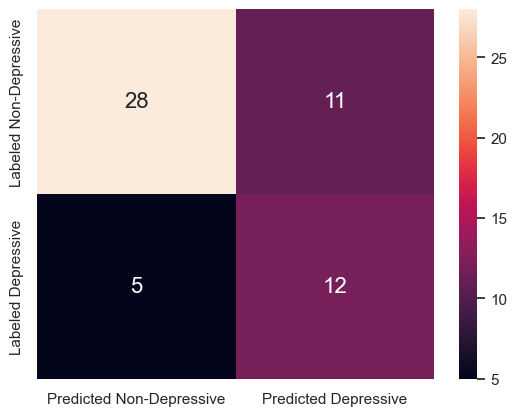

In [23]:
# Deriving confusion matrix from the best_classif_report, we forgot to add that code and lost the variable:

TP = round(17 * 0.71) # support multiplied by recall
FN = 17 - TP
TN = round(39 * 0.72) # support multiplied by recall
FP = 39 - TN

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = [[TN, FP], [FN, TP]]

df_cm = pd.DataFrame(array, ['Labeled Non-Depressive', 'Labeled Depressive'], ['Predicted Non-Depressive', 'Predicted Depressive'])
sn.set(font_scale=1.0)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16})

plt.show()